In [1]:
import vice
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.weight": "light",
    'text.latex.preamble' : r'\usepackage{siunitx,amsmath,helvet,sansmath}\sisetup{detect-all}\sansmath',
    "figure.dpi": 100,
    "date.autoformatter.minute": "%m/%d %H:%M"
})


In [2]:
print(vice.yields.sneia.fractional('c'))
print(vice.yields.agb.settings('c'))

5.7420404800000006e-06
cristallo11


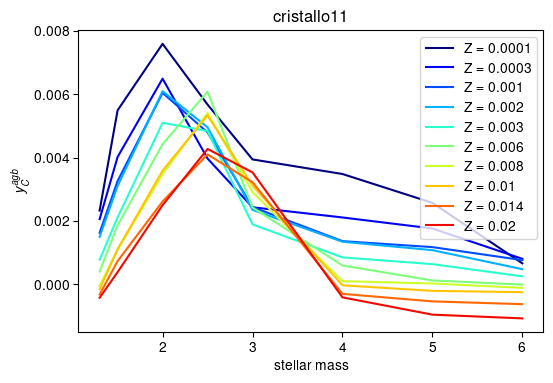

In [15]:
def plot_c_table(study = "cristallo11"):
    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    cmap = plt.get_cmap('jet')
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]

        plt.plot(m1, y, label=f"Z = {z}", c=cmap(i/N))

    plt.xlabel("stellar mass")
    plt.ylabel("$y_C^{agb}$")
    plt.legend()
    plt.title(study)

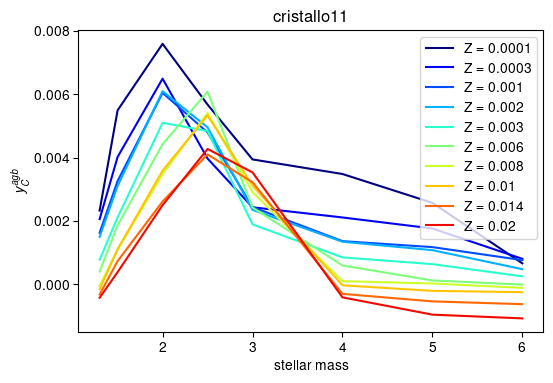

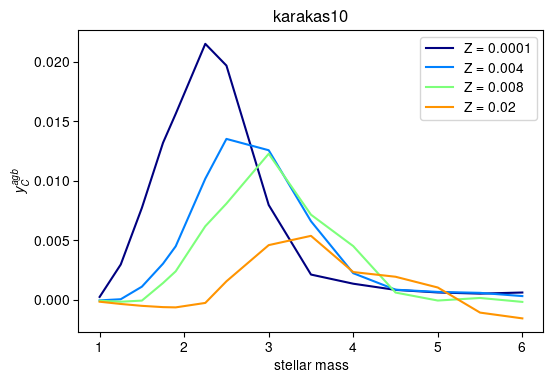

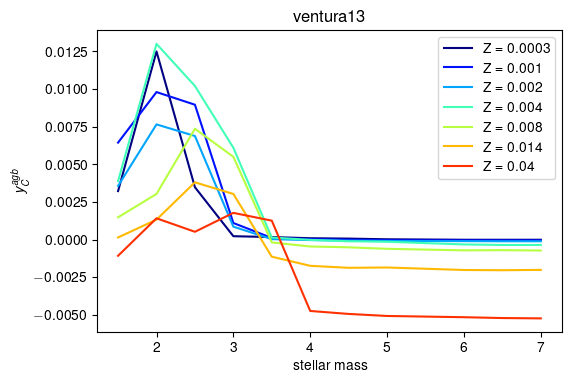

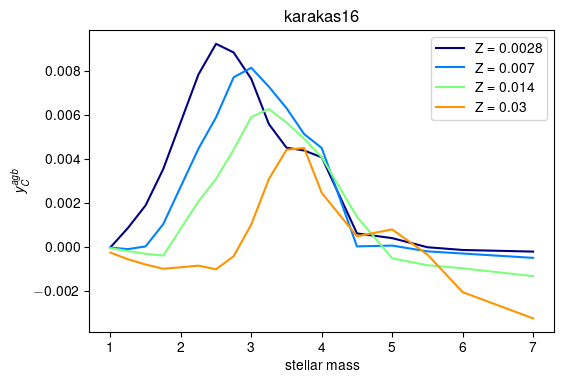

In [19]:
for study in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    plot_c_table(study)
    plt.show()

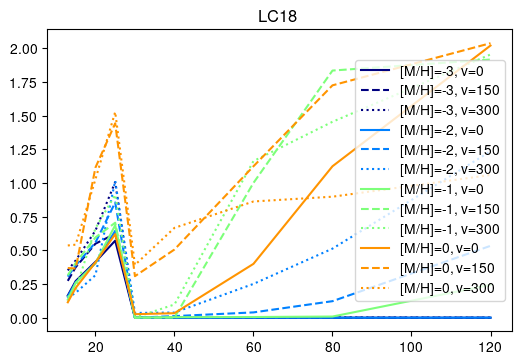

[0.001548777200030053, 1.6156077284818306e-06]


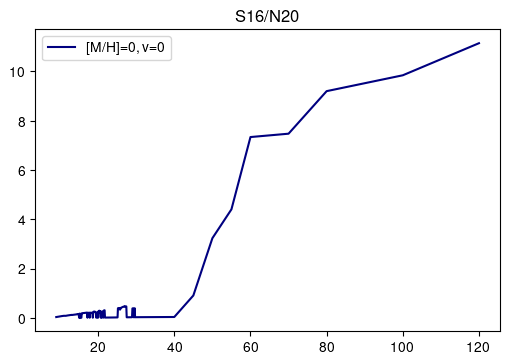

[0.005199112964456409, 5.914914109177602e-06]


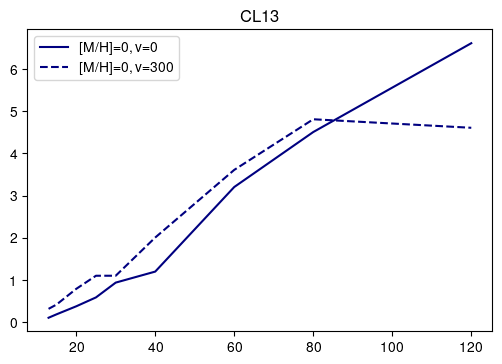

[0.004687901634796476, 5.253505827008813e-06]


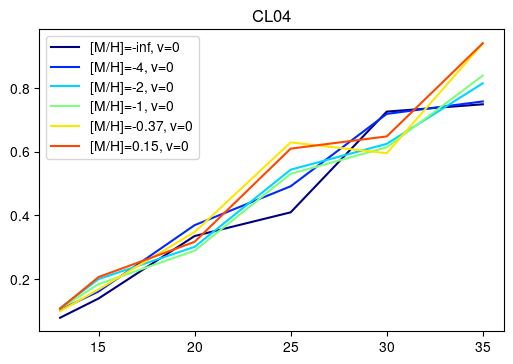

[-0.031295463201531884, 3.722085705109464e-05]


<ipython-input-99-d0cc4fcb7757>:19: ScienceWarning: Supernovae yields from the Chieffi & Limongi (2004), ApJ, 608, 405 study are sampled on a grid of stellar masses up to 35 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  print(vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity))


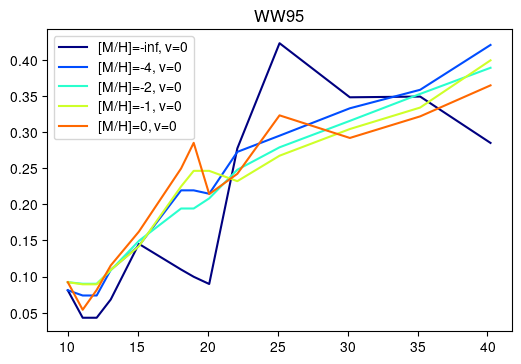

<ipython-input-99-d0cc4fcb7757>:19: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  print(vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity))
<ipython-input-99-d0cc4fcb7757>:19: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  print(vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity))


[0.0019060051732848018, 2.603593477886669e-06]


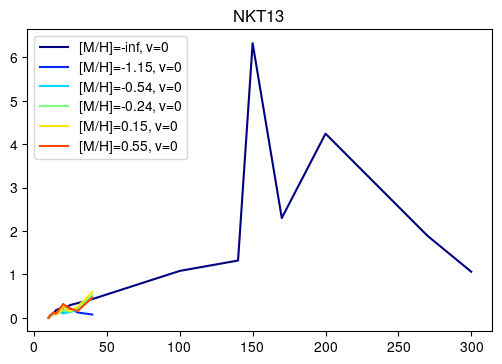

[0.002203029892145116, 2.5763064544118136e-06]


<ipython-input-99-d0cc4fcb7757>:19: ScienceWarning: Supernovae yields from the Nomoto, Kobayashi & Tominaga (2013), ARA&A, 51, 457 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  print(vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity))


In [99]:
for study, metalicity in [("LC18",0), ("S16/N20",0), ("CL13",0),("CL04",0.15), ("WW95",0), ("NKT13",0.15)]:
    metalicities = allowed_MoverH[study]
    
    N = len(metalicities)
    rotations = allowed_rotations[study]
    for i in range(N):
        for j in range(len(rotations)):
            rotation = rotations[j]
            MoverH = metalicities[i]
            table = vice.yields.ccsne.table("c", study=study, MoverH=MoverH, rotation=rotation)
            masses = table.masses
            yields = [table[mass] for mass in masses]

            plt.plot(masses, yields, label=f"[M/H]={MoverH}, v={rotation}", color=cmap(i/N), linestyle=["-", "--", ":"][j])
        
    plt.title(study)
    plt.legend()
    plt.show()
    print(vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity))

In [89]:
vice.yields.ccsne.table?

In [65]:
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    "CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }

In [91]:
allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

<ipython-input-136-961a055b7694>:10: ScienceWarning: Supernovae yields from the Chieffi & Limongi (2004), ApJ, 608, 405 study are sampled on a grid of stellar masses up to 35 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-136-961a055b7694>:10: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-136-961a055b7694>:10: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.f

Text(0, 0.5, 'fractional yield')

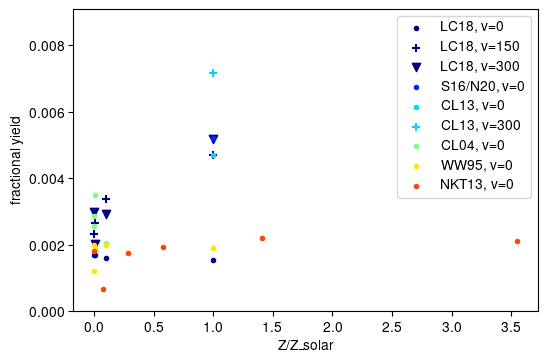

In [136]:
ccsne_studies = ["LC18", "S16/N20", "CL13","CL04","WW95","NKT13"]
N = len(ccsne_studies)
for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        plt.scatter(Z, y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=[".", "+", "v"][j])

plt.legend()
plt.ylim(0)
plt.xlabel("Z/Z\_solar")
plt.ylabel("fractional yield")